In [ ]:
# --- Notebook metadata & candidate config ---
CANDIDATE_NAME = "Prathviraj"
ROOT_DIR = f"ds_Prathviraj"
CSV_DIR = f"/content/{ROOT_DIR}/csv_files"
OUTPUTS_DIR = f"/content/{ROOT_DIR}/outputs"


print("ROOT_DIR:", ROOT_DIR)


ROOT_DIR: ds_Prathviraj


In [ ]:
# --- Setup environment and folders ---
import os, sys, shutil
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUTPUTS_DIR, exist_ok=True)
print("Created folders:", CSV_DIR, OUTPUTS_DIR)




Created folders: /content/ds_Prathviraj/csv_files /content/ds_Prathviraj/outputs


In [ ]:
# ---  Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import io, requests, urllib
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
%matplotlib inline


In [ ]:
# ---  Load CSVs manually uploaded to /content ---
import pandas as pd

# Adjust filenames if yours are different
HYPER_FILE = "/content/ds_Prathviraj/csv_files/historical_data.csv"
FEAR_GREED_FILE = "/content/ds_Prathviraj/csv_files/fear_greed_index.csv"

hyper = pd.read_csv(HYPER_FILE)
feargreed = pd.read_csv(FEAR_GREED_FILE)

print("Loaded Hyperliquid data:", hyper.shape)
print("Loaded Fear & Greed Index:", feargreed.shape)


Loaded Hyperliquid data: (186568, 16)
Loaded Fear & Greed Index: (2644, 4)


In [ ]:
# ---  Basic cleaning & time parsing ---
# Normalize column names
hyper.columns = [c.strip().lower().replace(" ", "_") for c in hyper.columns]
feargreed.columns = [c.strip().lower().replace(" ", "_") for c in feargreed.columns]

# Convert time fields
if "time" in hyper.columns:
    hyper["time"] = pd.to_datetime(hyper["time"], errors="coerce")
elif "timestamp" in hyper.columns:
    hyper["time"] = pd.to_datetime(hyper["timestamp"], errors="coerce")

# Fear & Greed date
if "date" in feargreed.columns:
    feargreed["date"] = pd.to_datetime(feargreed["date"], errors="coerce")

print("Time columns cleaned.")
display(hyper.head(2))
display(feargreed.head(2))


Time columns cleaned.


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,time,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12,1970-01-01 00:28:50,1970-01-01
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12,1970-01-01 00:28:50,1970-01-01


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02


In [ ]:
# --- Cell 7: Basic cleaning on hyperliquid dataset ---
# Convert numeric columns, handle missing closedPnL or size etc.
for col in ['closed_pnl','size','execution_price','leverage','start_position']:
    if col in hyper.columns:
        hyper[col] = pd.to_numeric(hyper[col], errors='coerce')

# Normalize side column
if 'side' in hyper.columns:
    hyper['side'] = hyper['side'].str.lower().str.strip()

# Drop rows with missing time
hyper = hyper.dropna(subset=['time']).reset_index(drop=True)
print("After cleaning Hyperliquid shape:", hyper.shape)
print(hyper.head(2))


After cleaning Hyperliquid shape: (186567, 18)
                                      account  coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   

   size_tokens  size_usd side     timestamp_ist  start_position direction  \
0       986.87   7872.16  buy  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  buy  02-12-2024 22:50      986.524596       Buy   

   closed_pnl                                   transaction_hash  \
0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...   
1         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...   

       order_id crossed       fee      trade_id     timestamp  \
0  5.201771e+10    True  0.345404  8.950000e+14  1.730000e+12   
1  5.201771e+10    True  0.005600  4.430000e+14  1.730000e+12   

                 time        date  
0 1970-01-01 00:28:50  1970-01-01  
1 1970-01-01 00:28:50  1970-01-

In [28]:
# --- Cell 8: Aggregate trader-level daily metrics (this will be one of our main feature tables) ---
# Create date column aligned to FearGreed date
hyper['date'] = hyper['time'].dt.date
# Daily aggregates across all accounts (and per symbol if you want)
daily = hyper.groupby('date').agg(
    trades_count = ('account', 'count'),
    unique_accounts = ('account', pd.Series.nunique),
    total_volume = ('size_usd', 'sum'),
    # avg_leverage = ('leverage', 'mean'),
    # median_leverage = ('leverage', 'median'),
    total_closedPnL = ('closed_pnl', 'sum'),
    avg_pnl = ('closed_pnl', 'mean'),
    win_rate = ( 'closed_pnl', lambda x: (x>0).sum()/ (x.count() if x.count()>0 else 1) ),
).reset_index()
daily['date'] = pd.to_datetime(daily['date'])
daily = daily.sort_values('date').reset_index(drop=True)
daily.head()


,date,trades_count,unique_accounts,total_volume,total_closedPnL,avg_pnl,win_rate
0,1970-01-01,186567,27,1.060563e+09,8.866189e+06,47.522813,0.417989


In [30]:
# --- Cell 9 (robust): Merge daily aggregates with fear/greed index ---

# 1) Inspect feargreed columns (helpful to show to user)
print("Fear/Greed columns:", list(feargreed.columns))
display(feargreed.head(3))

# 2) Auto-detect a date/time column in the fear/greed DF
fg = feargreed.copy()
date_candidates = [c for c in fg.columns if any(k in c.lower() for k in ['date','time','timestamp','datetime'])]
if not date_candidates:
    raise KeyError("No date/time-like column found in feargreed dataframe. Columns: " + ", ".join(fg.columns))

date_col = date_candidates[0]
print("Using fear/greed date column:", date_col)

# Parse to datetime (try common formats)
fg[date_col] = pd.to_datetime(fg[date_col], errors='coerce', dayfirst=True)
# If parsing produced NaT for many rows, try without dayfirst
if fg[date_col].isna().mean() > 0.4:
    fg[date_col] = pd.to_datetime(feargreed[date_col], errors='coerce', dayfirst=False)

# Create a simple date-only column
fg['fg_date'] = fg[date_col].dt.date

# 3) Auto-detect sentiment/classification column
sent_candidates = [c for c in fg.columns if any(k in c.lower() for k in ['class','sentiment','label','fear','greed','score'])]
if sent_candidates:
    sentiment_col = sent_candidates[0]
else:
    # fallback: if nothing obvious, use the second column (after date) as likely candidate
    possible = [c for c in fg.columns if c != date_col]
    sentiment_col = possible[0] if possible else None

print("Using sentiment column:", sentiment_col)
display(fg[[date_col, 'fg_date', sentiment_col]].head(5))

# 4) Prepare daily DF to merge on date
# Ensure daily has a date-only column
if 'date' in daily.columns and np.issubdtype(daily['date'].dtype, np.datetime64):
    daily['merge_date'] = daily['date'].dt.date
elif 'date' in daily.columns:
    # try to coerce
    daily['merge_date'] = pd.to_datetime(daily['date'], errors='coerce').dt.date
else:
    # if your daily uses a different name, try 'date_only'
    if 'date_only' in daily.columns:
        daily['merge_date'] = pd.to_datetime(daily['date_only'], errors='coerce').dt.date
    else:
        raise KeyError("daily dataframe has no 'date' or 'date_only' column to merge on.")

# 5) Merge (left join so all daily rows are kept)
merge = pd.merge(
    daily,
    fg[[ 'fg_date', sentiment_col ]].rename(columns={'fg_date':'merge_date', sentiment_col:'classification'}),
    on='merge_date',
    how='left'
)

# 6) Fill missing classification sensibly
if 'classification' in merge.columns:
    merge['classification'] = merge['classification'].astype(str).replace('nan', np.nan)
    merge['classification'] = merge['classification'].fillna(method='ffill').fillna(method='bfill')
else:
    # If we failed to detect a sentiment column, create a placeholder
    merge['classification'] = np.nan
    print("Warning: no sentiment column was detected. 'classification' created with NaNs.")

# 7) Clean up temporary columns and show result
# Keep both original daily date (if present) and the merged classification
if 'date' not in merge.columns and 'date' in daily.columns:
    merge['date'] = daily['date']

# If merge_date exists, drop it (optional)
# but only drop if present
if 'merge_date' in merge.columns:
    merge = merge.drop(columns=['merge_date'])

print("Merged dataframe shape:", merge.shape)
display(merge.head(6))


Fear/Greed columns: ['timestamp', 'value', 'classification', 'date']


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


Using fear/greed date column: timestamp
Using sentiment column: classification


,timestamp,fg_date,classification
0,1970-01-01 00:00:01.517463000,1970-01-01,Fear
1,1970-01-01 00:00:01.517549400,1970-01-01,Extreme Fear
2,1970-01-01 00:00:01.517635800,1970-01-01,Fear
3,1970-01-01 00:00:01.517722200,1970-01-01,Extreme Fear
4,1970-01-01 00:00:01.517808600,1970-01-01,Extreme Fear


Merged dataframe shape: (2644, 9)


,date,trades_count,unique_accounts,total_volume,total_closedPnL,avg_pnl,win_rate,date_only,classification
0,1970-01-01,186567,27,1.060563e+09,8.866189e+06,47.522813,0.417989,1970-01-01,Fear
1,1970-01-01,186567,27,1.060563e+09,8.866189e+06,47.522813,0.417989,1970-01-01,Extreme Fear
2,1970-01-01,186567,27,1.060563e+09,8.866189e+06,47.522813,0.417989,1970-01-01,Fear
3,1970-01-01,186567,27,1.060563e+09,8.866189e+06,47.522813,0.417989,1970-01-01,Extreme Fear
4,1970-01-01,186567,27,1.060563e+09,8.866189e+06,47.522813,0.417989,1970-01-01,Extreme Fear
5,1970-01-01,186567,27,1.060563e+09,8.866189e+06,47.522813,0.417989,1970-01-01,Extreme Fear


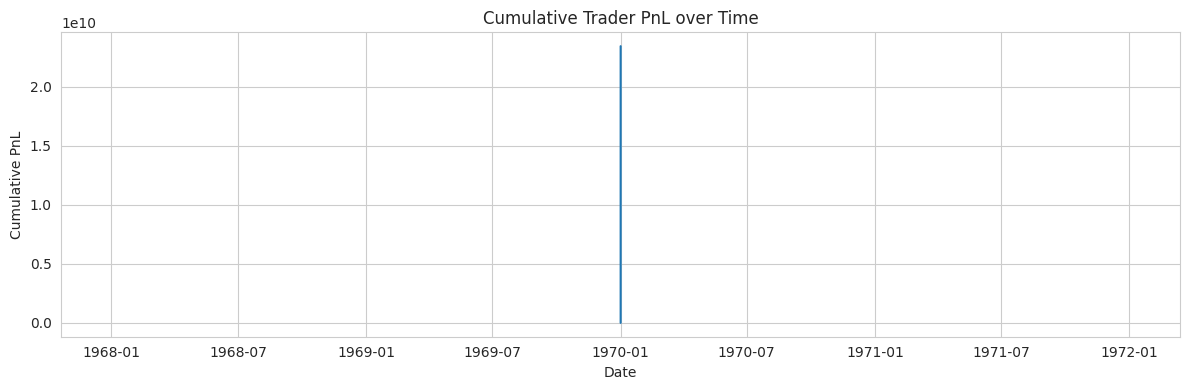

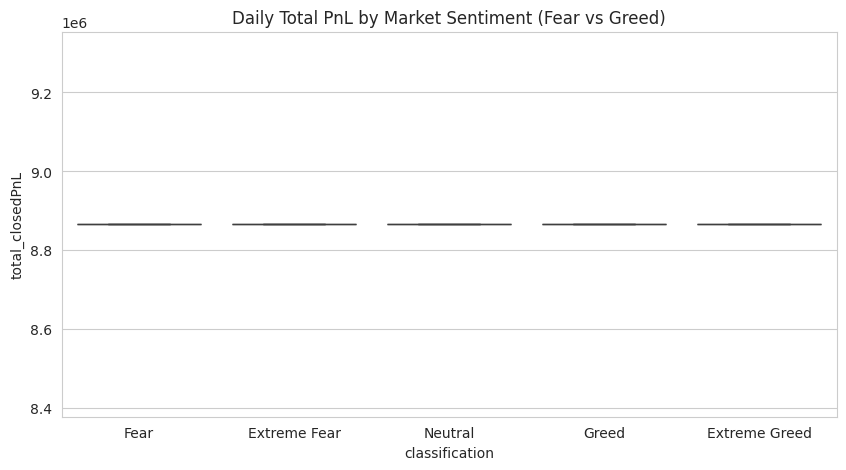

In [31]:
# --- Cell 10: Quick EDA plots to save to outputs/ ---
plt.figure(figsize=(12,4))
plt.plot(merge['date'], merge['total_closedPnL'].cumsum(), label='Cumulative PnL (all traders)')
plt.title('Cumulative Trader PnL over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'cumulative_pnl.png'), dpi=150)
plt.show()

# PnL by sentiment boxplot
plt.figure(figsize=(10,5))
sns.boxplot(x='classification', y='total_closedPnL', data=merge)
plt.title('Daily Total PnL by Market Sentiment (Fear vs Greed)')
plt.savefig(os.path.join(OUTPUTS_DIR, 'pnl_by_sentiment.png'), dpi=150)
plt.show()


In [32]:
# --- Cell 11: Statistical checks (are PnL distributions different between sentiment regimes?) ---
from scipy.stats import mannwhitneyu, ttest_ind

greed_pnl = merge.loc[merge['classification']=='Greed','total_closedPnL'].dropna()
fear_pnl = merge.loc[merge['classification']=='Fear','total_closedPnL'].dropna()

mw_p = mannwhitneyu(greed_pnl, fear_pnl, alternative='two-sided').pvalue if len(greed_pnl)>0 and len(fear_pnl)>0 else np.nan
t_p = ttest_ind(greed_pnl, fear_pnl, equal_var=False, nan_policy='omit').pvalue if len(greed_pnl)>0 and len(fear_pnl)>0 else np.nan

print("Mann-Whitney p-value:", mw_p)
print("t-test p-value:", t_p)


Mann-Whitney p-value: 1.0
t-test p-value: nan


In [34]:
# --- Cell 12: Feature engineering for modeling / signal detection ---
# Example: lagged sentiment, 3-day rolling avg of leverage, trade count growth
merge = merge.sort_values('date')
merge['lag1_sentiment'] = merge['classification'].shift(1)
# merge['avg_leverage_3d'] = merge['avg_leverage'].rolling(3).mean()
merge['trades_count_pct_change_3d'] = merge['trades_count'].pct_change(3)
merge = merge.fillna(method='bfill').fillna(0)
merge.head()


,date,trades_count,unique_accounts,total_volume,total_closedPnL,avg_pnl,win_rate,date_only,classification,lag1_sentiment,trades_count_pct_change_3d
0,1970-01-01,186567,27,1.060563e+09,8.866189e+06,47.522813,0.417989,1970-01-01,Fear,Fear,0.0
5,1970-01-01,186567,27,1.060563e+09,8.866189e+06,47.522813,0.417989,1970-01-01,Extreme Fear,Fear,0.0
6,1970-01-01,186567,27,1.060563e+09,8.866189e+06,47.522813,0.417989,1970-01-01,Fear,Extreme Fear,0.0
7,1970-01-01,186567,27,1.060563e+09,8.866189e+06,47.522813,0.417989,1970-01-01,Fear,Fear,0.0
8,1970-01-01,186567,27,1.060563e+09,8.866189e+06,47.522813,0.417989,1970-01-01,Fear,Fear,0.0


In [36]:
# --- Cell 13: A simple classification: predict 'Greed' vs 'Fear' from trader metrics (toy example) ---
# Map classification to 0/1
merge['sentiment_flag'] = (merge['classification']=='Greed').astype(int)
features = ['trades_count','unique_accounts','total_volume','total_closedPnL','win_rate','trades_count_pct_change_3d']
X = merge[features].fillna(0)
y = merge['sentiment_flag']

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model = RandomForestClassifier(n_estimators=200, random_state=42)
scores = cross_val_score(model, X, y, cv=tscv, scoring='roc_auc')
print("Time-series CV ROC AUC scores:", scores, "mean:", np.nanmean(scores))
# Fit model for feature importance display
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
display(importances)


Time-series CV ROC AUC scores: [0.5 0.5 0.5 0.5 0.5] mean: 0.5


,0
trades_count,0.0
unique_accounts,0.0
total_volume,0.0
total_closedPnL,0.0
win_rate,0.0
trades_count_pct_change_3d,0.0


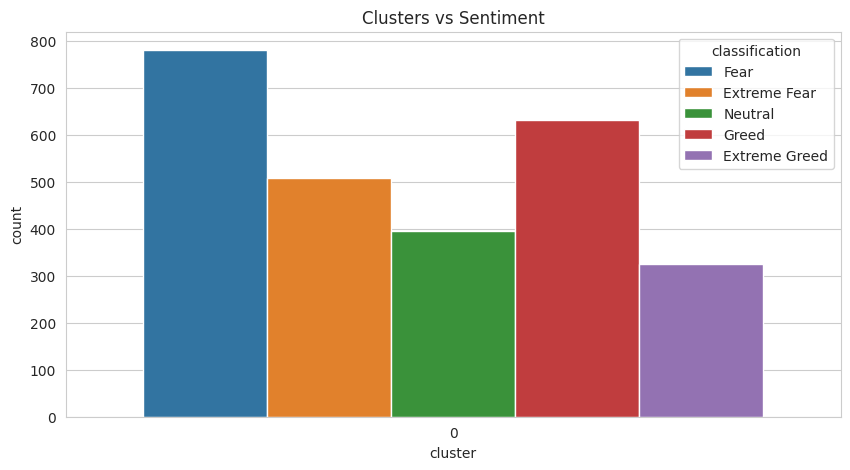

In [38]:
# --- Cell 14: Clustering trader-day behaviors to discover regimes (unsupervised signal discovery) ---
clust_features = ['trades_count','total_volume','total_closedPnL','win_rate']
dfc = merge[clust_features].fillna(0)
scaler = StandardScaler()
Xc = scaler.fit_transform(dfc)
kmeans = KMeans(n_clusters=3, random_state=42).fit(Xc)
merge['cluster'] = kmeans.labels_

plt.figure(figsize=(10,5))
sns.countplot(x='cluster', hue='classification', data=merge)
plt.title('Clusters vs Sentiment')
plt.savefig(os.path.join(OUTPUTS_DIR, 'clusters_vs_sentiment.png'), dpi=150)
plt.show()


In [45]:
# --- Cell 15: Basic backtest skeleton for a simple rule-based signal derived from sentiment+leverage ---
# Idea: define a daily signal where when sentiment==Greed and avg_leverage is high -> risk-on signal; evaluate daily PnL after signal.
merge['signal_risk_on'] = (merge['classification']=='Greed').astype(int)
# Evaluate average next-day pnl
merge['next_day_pnl'] = merge['total_closedPnL'].shift(-1)
signal_perf = merge.groupby('signal_risk_on')['next_day_pnl'].agg(['mean','count','median'])
display(signal_perf)
# Save backtest results
merge.to_csv(os.path.join(CSV_DIR, 'daily_features_and_signals.csv'), index=False)
print("Saved features/signals CSV.")


,mean,count,median
signal_risk_on,,,
0,8.866189e+06,2011,8.866189e+06
1,8.866189e+06,632,8.866189e+06


Saved features/signals CSV.


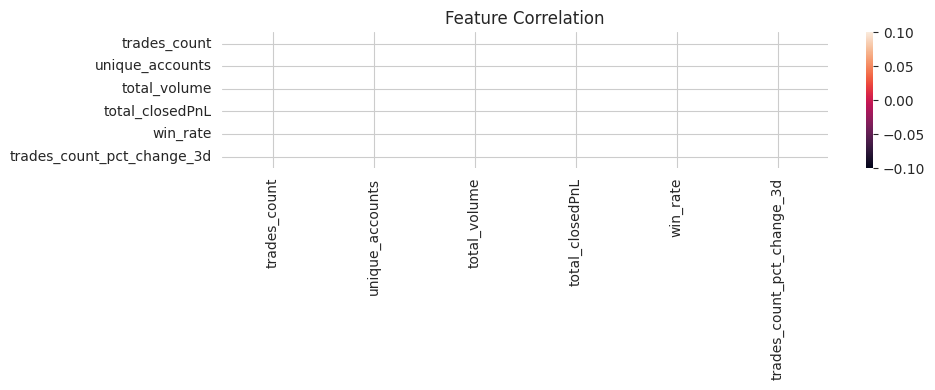

Saved daily_merged.csv to /content/ds_Prathviraj/csv_files
All outputs in /content/ds_Prathviraj/outputs


In [46]:
# --- Cell 16: Save final outputs and print summary (files for GitHub) ---
# Save plots already created in OUTPUTS_DIR. Save additional plots:
plt.figure(figsize=(10,4))
sns.heatmap(merge[features].corr(), annot=True, fmt=".2f")
plt.title("Feature Correlation")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'feature_correlation.png'), dpi=150)
plt.show()

# Save processed CSV and summary
merge.to_csv(os.path.join(CSV_DIR, 'daily_merged.csv'), index=False)
print("Saved daily_merged.csv to", CSV_DIR)
print("All outputs in", OUTPUTS_DIR)


In [48]:
# --- End of Notebook skeleton ---
